##### 前面都差不多都是資料整理

In [1]:
import os
import cv2
import numpy as np

DATA_DIR = "flowers"
IMG_SIZE = 128


X = []
y = []

label_map = {
    "daisy": 0,
    "dandelion": 1,
    "rose": 2,
    "sunflower": 3,
    "tulip": 4
}
# 這邊是把圖片變成向量 就類似csv
for label_name, label in label_map.items():
    folder = os.path.join(DATA_DIR, label_name)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # 這邊可以變成灰階
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # 這邊是用來變成128*128
        X.append(img.flatten())   # 128×128 → 16384
        y.append(label)

# 這邊把它變成numpy
X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

(4317, 16384) (4317,)


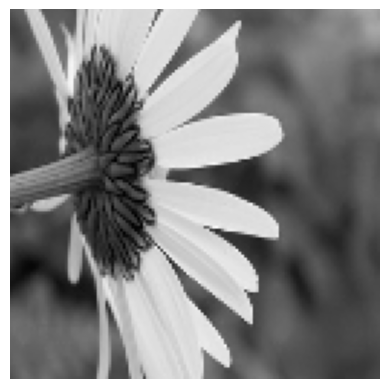

花朵編號： 0


In [2]:
# 會發現多一個因為是欄位名裡面是 0 1 2 3 4 5 6 
# 所以要用掉
import matplotlib.pyplot as plt
import numpy as np
image = X[0,:].reshape(128,128)
plt.imshow(image , cmap='gray')
plt.axis('off')
plt.show()
print('花朵編號：' , y[0])


原始資料維度: (4317, 16384)
開始進行 LDA...
LDA 後維度: (4317, 4)


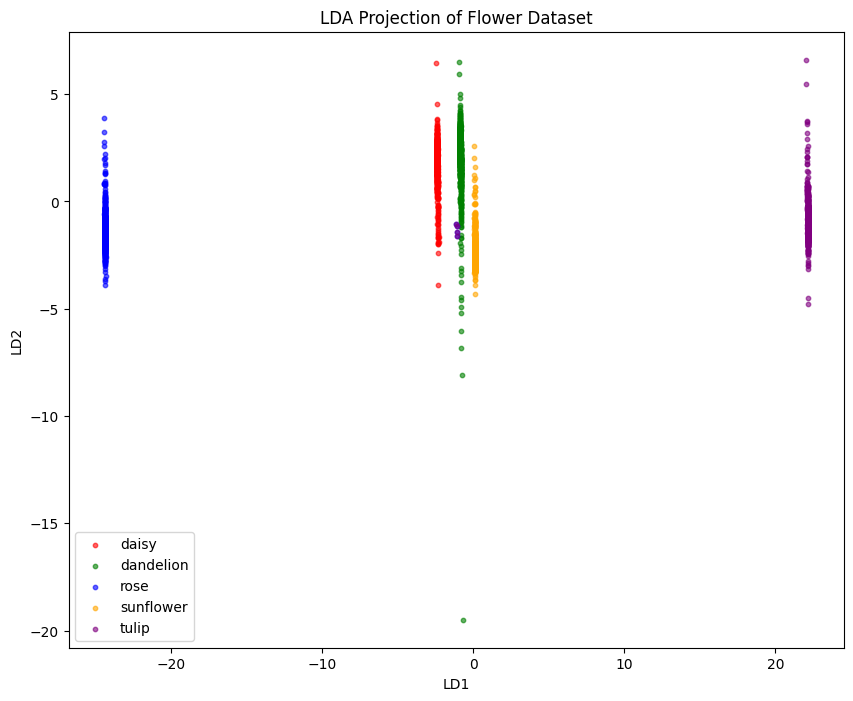

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

# --- 假設您已經跑完上面的讀圖程式碼，擁有 X 和 y ---


print(f"原始資料維度: {X.shape}")


# 類別數有 5 (Daisy, Dandelion, Rose, Sunflower, Tulip)
# 所以 LDA 最多只能降到 5-1 = 4 維
print("開始進行 LDA...")
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X, y)

print(f"LDA 後維度: {X_lda.shape}") 
# 預期結果: (樣本數, 4)

# --- 視覺化 (選前兩個維度畫圖) ---
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue', 'orange', 'purple']
target_names = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

for i, color, target_name in zip(range(5), colors, target_names):
    plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], alpha=0.6, c=color, label=target_name, s=10)

plt.legend(loc='best')
plt.title('LDA Projection of Flower Dataset')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.show()

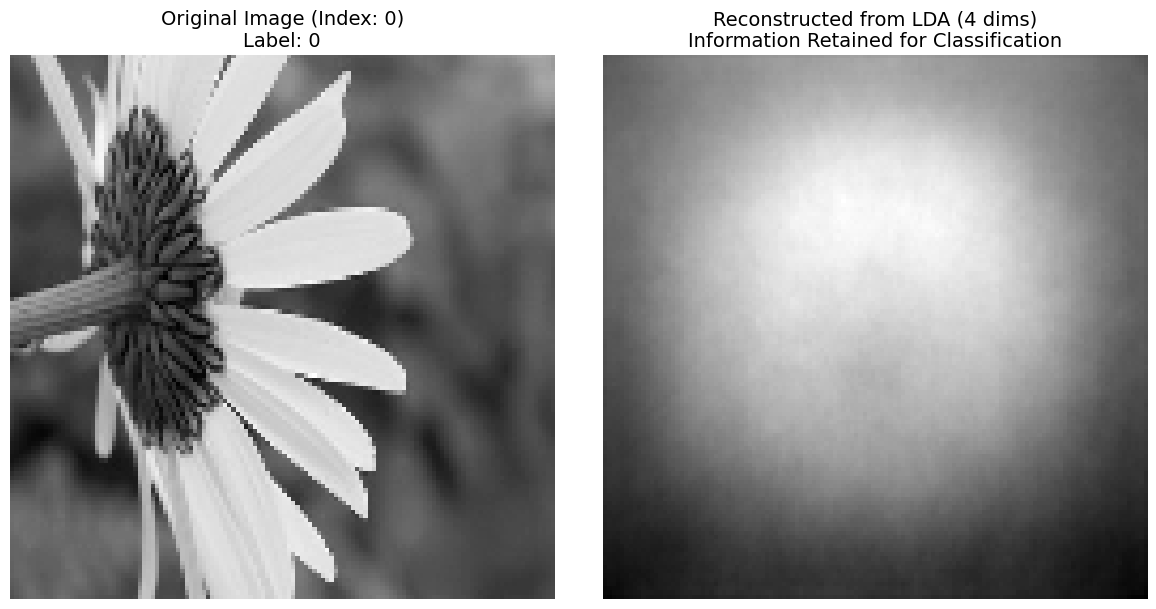

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 設定想要觀察的圖片索引
idx = 0  # 您可以隨意改成其他數字，例如 10, 50, 200

# 1. 取得原始圖片
original_img = X[idx].reshape(128, 128)
true_label = y[idx]

# 2. 取得 LDA 的相關參數
# W: 投影權重矩陣 (16384, 4)
W = lda.scalings_
# z: 該張圖片在 LDA 4維空間中的座標 (4,)
z = X_lda[idx]
# mu: 全體資料的平均值 (16384,) -> LDA 運算時會扣掉這個，還原時要加回來
mu = lda.xbar_

# 3. 投影回原空間 (Reconstruction)
# 公式: X_recon = (z @ W.T) + mu
# 注意: LDA 不是正交轉換，這裡的還原是「近似」，代表該圖片在 LDA 子空間的投影
x_lda_back_vec = np.dot(z, W.T) + mu

# 確保數值在合理範圍 (雖然不做也可以顯示，但為了嚴謹)
# 圖片像素通常在 0-255 (如果是 uint8) 或 0-1 (如果是 float)
# x_lda_back_vec = np.clip(x_lda_back_vec, 0, 255)

# 轉回圖片形狀
lda_reconstructed_img = x_lda_back_vec.reshape(128, 128)

# --- 繪圖比較 ---
plt.figure(figsize=(12, 6))

# 左圖：原始圖片
plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap="gray")
plt.title(f"Original Image (Index: {idx})\nLabel: {true_label}", fontsize=14)
plt.axis("off")

# 右圖：LDA 重建圖片
plt.subplot(1, 2, 2)
plt.imshow(lda_reconstructed_img, cmap="gray")
plt.title(f"Reconstructed from LDA (4 dims)\nInformation Retained for Classification", fontsize=14)
plt.axis("off")

plt.tight_layout()
plt.show()

- 會覺得沒東東很正常畢竟變成4dim而已

- 然後看看效果怎麼樣統計上的效果

In [36]:


# 假設 X_train, y_train 已經準備好
lda = LinearDiscriminantAnalysis() # n_components 設為 None 以查看所有維度
X_lda = lda.fit_transform(X, y)

# 1. 解釋變異量比率
print("解釋變異量 (Explained Variance Ratio):")
print(lda.explained_variance_ratio_)
# 如果第一個值是 0.95，代表第一軸就解釋了 95% 的區別資訊，分得非常好。

解釋變異量 (Explained Variance Ratio):
[0.96300616 0.01445299 0.01184994 0.01069091]


In [37]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = lda.predict(X)

# 2. 混淆矩陣與報告
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

print("\nClassification Report:")
print(classification_report(y, y_pred))


Confusion Matrix:
[[ 720   26    0   18    0]
 [  22 1001    0   29    0]
 [   1    3  780    0    0]
 [   5   13    0  715    0]
 [   1    3    0    0  980]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       764
           1       0.96      0.95      0.95      1052
           2       1.00      0.99      1.00       784
           3       0.94      0.98      0.96       733
           4       1.00      1.00      1.00       984

    accuracy                           0.97      4317
   macro avg       0.97      0.97      0.97      4317
weighted avg       0.97      0.97      0.97      4317



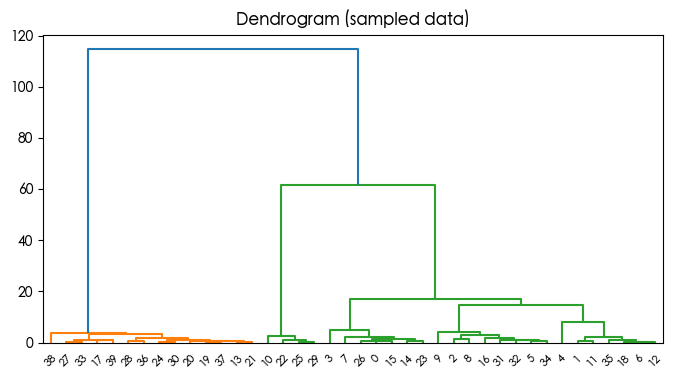

In [17]:
from scipy.cluster.hierarchy import dendrogram , linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Heiti TC'  # 或 'Heiti TC'
plt.rcParams['axes.unicode_minus'] = False   # 解決負號顯示成方框

import numpy as np
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage

idx = np.random.choice(len(X_lda), size=40, replace=False)

linked_sub = linkage(X_lda[idx], method='ward')

plt.figure(figsize=(8, 4))
dendrogram(
    linked_sub,
    color_threshold=None   # 先畫完整樹
)
plt.title("Dendrogram (sampled data)")
plt.show()


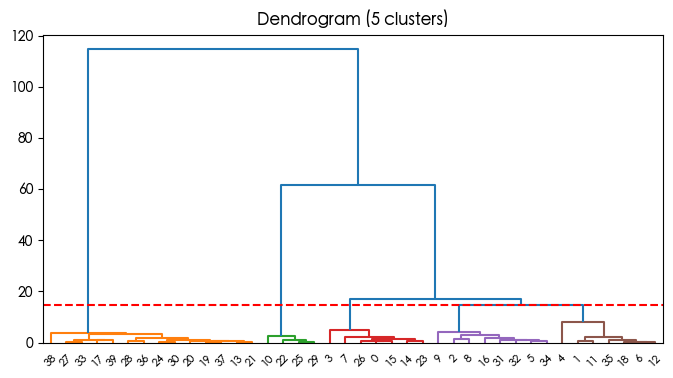

In [18]:
plt.figure(figsize=(8, 4))
dendrogram(
    linked_sub,
    color_threshold=linked_sub[-4, 2]  # 關鍵這一行
)
plt.title("Dendrogram (5 clusters)")
cut_height = linked_sub[-4, 2]
plt.axhline(y=cut_height, color='r', linestyle='--')
plt.show()


- 其實這邊就可以稍微看出來分的感覺還行

In [19]:
from scipy.cluster.hierarchy import linkage

linked = linkage(X_lda, method='ward')
from scipy.cluster.hierarchy import fcluster

cluster_labels = fcluster(linked, t=5, criterion='maxclust')

print(cluster_labels.shape)  # (4317,)
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(y, cluster_labels)
print("Adjusted Rand Index (ARI):", ari)



(4317,)
Adjusted Rand Index (ARI): 0.9198787619607172


- 這邊就可以看出分類效果變很好

In [20]:
import pandas as pd

ct = pd.crosstab(
    cluster_labels,
    y,
    rownames=["Cluster"],
    colnames=["True Label"]
)

print(ct)


True Label    0     1    2    3    4
Cluster                             
1             0     0    0    0  980
2             0     0  780    0    0
3             2    17    0  695    0
4           692     4    0    0    0
5            70  1031    4   38    4


- 這邊確實不錯

In [21]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=5,
    random_state=42,
    n_init=20
)

kmeans_labels = kmeans.fit_predict(X_lda)


In [22]:
from sklearn.metrics import adjusted_rand_score

ari_kmeans = adjusted_rand_score(y, kmeans_labels)
print("KMeans ARI:", ari_kmeans)


KMeans ARI: 0.9328706572501682


In [23]:
import pandas as pd

ct_kmeans = pd.crosstab(
    kmeans_labels,
    y,
    rownames=["KMeans Cluster"],
    colnames=["True Label"]
)

print(ct_kmeans)


True Label        0    1    2    3    4
KMeans Cluster                         
0                26  999    3   11    3
1                 0    0    0    0  980
2                 0    0  780    0    0
3                18   31    0  718    0
4               720   22    1    4    1


- k mean也很不錯

In [24]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(
    n_clusters=5,
    metric="euclidean",
    random_state=42,
    method="pam"
)

kmedoids_labels = kmedoids.fit_predict(X_lda)


In [25]:
ari_kmedoids = adjusted_rand_score(y, kmedoids_labels)
print("KMedoids ARI:", ari_kmedoids)


KMedoids ARI: 0.9334233547106005


In [26]:
ct_kmedoids = pd.crosstab(
    kmedoids_labels,
    y,
    rownames=["KMedoids Cluster"],
    colnames=["True Label"]
)

print(ct_kmedoids)


True Label          0     1    2    3    4
KMedoids Cluster                          
0                   0     0  780    0    0
1                   0     0    0    0  980
2                 720    21    1    4    1
3                  18    31    0  718    0
4                  26  1000    3   11    3


In [45]:
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X , y)

In [46]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=5000,
    random_state=42
)

logistic.fit(X_lda, y)                 # 訓練
logistic_labels = logistic.predict(X_lda)  # 預測

print(logistic_labels.shape)


(4317,)


/Users/papaya/.venvs/py312-arm/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [47]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y, logistic_labels))


Accuracy: 0.9958304378040306


In [48]:
from sklearn.metrics import adjusted_rand_score
print("ARI:", adjusted_rand_score(y, logistic_labels))


ARI: 0.98910741857588


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. 修正切分比例：確保 train 是大份的 (test_size=0.2 表示 20% 當測試)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. LDA 降維
lda = LDA(n_components=None) # None 會自動取最大可用維度 (類別數-1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

# 4. Logistic Regression
# 修正警告：新版 sklearn 建議不需特別指定 multi_class，預設就是 auto/multinomial
logistic = LogisticRegression(
    solver="lbfgs",
    max_iter=5000,
    random_state=42
)

logistic.fit(X_train_lda, y_train)
y_pred = logistic.predict(X_test_lda)

# 5. 再次檢查結果
print(f"Train Data Shape: {X_train_lda.shape} (應該要比較大)")
print(f"Test Data Shape: {X_test_lda.shape} (應該要比較小)")
print("-" * 30)
print("New Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Train Data Shape: (3453, 4) (應該要比較大)
Test Data Shape: (864, 4) (應該要比較小)
------------------------------
New Accuracy: 0.2048611111111111

Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.20      0.20       153
           1       0.19      0.04      0.06       210
           2       0.19      0.30      0.23       157
           3       0.15      0.10      0.12       147
           4       0.25      0.39      0.30       197

    accuracy                           0.20       864
   macro avg       0.19      0.21      0.18       864
weighted avg       0.19      0.20      0.18       864



In [57]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

k_values = list(range(1, 21, 2))
mean_accuracies = []

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=20
)

for k in k_values:
    pipe = Pipeline([
        ("knn", KNeighborsClassifier(
            n_neighbors=k
        ))
    ])

    scores = cross_val_score(
        pipe,
        X_train_lda,
        y_train,
        cv=cv,
        scoring="accuracy"
    )

    mean_accuracies.append(scores.mean())
    print(f"k={k:2d}, Accuracy={scores.mean()}")

best_k = k_values[np.argmax(mean_accuracies)]
print("Best k =", best_k)


k= 1, Accuracy=0.9849401203884309
k= 3, Accuracy=0.9820432475513329
k= 5, Accuracy=0.9808850856771325
k= 7, Accuracy=0.979726923802932
k= 9, Accuracy=0.9797265043310472
k=11, Accuracy=0.9791476331298895
k=13, Accuracy=0.9768300509658339
k=15, Accuracy=0.9774093416388766
k=17, Accuracy=0.976540615365255
k=19, Accuracy=0.974803582289897
Best k = 1


In [58]:
# 做knn 這邊k = 1
final_pipe = Pipeline([
    ("knn", KNeighborsClassifier(
        n_neighbors=best_k,
    ))
])


final_pipe.fit(X_train_lda, y_train)


y_pred = final_pipe.predict(X_test_lda)
test_accuracy = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"測試集 (Test Set) 辨識正確率: {test_accuracy}")



------------------------------
測試集 (Test Set) 辨識正確率: 0.20601851851851852


- 可以看到效果都沒有到很好

In [5]:
import pandas as pd

df = pd.DataFrame(
    X_lda,
    columns=[f"PC{i+1}" for i in range(X_lda.shape[1])]
)

# 群組一定要是類別（字串最保險）
df["group"] = y.astype(str)

df.head()


,PC1,PC2,PC3,PC4,group
0,-2.407946,2.352322,-1.211370,3.727329,0
1,-2.396739,2.712282,-0.285725,1.309609,0
2,-2.389259,1.940888,0.331131,2.210179,0
3,-2.378991,0.163800,-1.016720,1.675137,0
4,-2.403186,1.756299,-1.194780,3.952368,0


In [7]:
print(df.columns)


Index(['PC1', 'PC2', 'PC3', 'PC4', 'group'], dtype='object')


In [8]:
from statsmodels.multivariate.manova import MANOVA

formula = "PC1 + PC2 + PC3 + PC4 ~ group"
maov = MANOVA.from_formula(formula, data=df)
print(maov.mv_test())



                      Multivariate linear model
                                                                      
-----------------------------------------------------------------------
         Intercept         Value   Num DF    Den DF    F Value   Pr > F
-----------------------------------------------------------------------
            Wilks' lambda  0.2392  4.0000  4309.0000  3426.9504  0.0000
           Pillai's trace  0.7608  4.0000  4309.0000  3426.9504  0.0000
   Hotelling-Lawley trace  3.1812  4.0000  4309.0000  3426.9504  0.0000
      Roy's greatest root  3.1812  4.0000  4309.0000  3426.9504  0.0000
----------------------------------------------------------------------
                                                                      
----------------------------------------------------------------------
         group           Value    Num DF   Den DF     F Value   Pr > F
----------------------------------------------------------------------
          Wilks' lambd